# Day4.1 VGGNet & ResNet

### 실습 목표
- Pretrained 된 VGGNet과 ResNet을 불러와 모델의 구조 확인해보기
- Pretrained 된 VGGNet과 ResNet을 불러와 Fine-Tuning을 통해 CIFAR-10 데이터 셋 분류해보기

<details>
<summary>데이터셋 상세</summary>

  - 일상에서 발견할 수 있는 Object들에 대한 32x32 크기의 컬러 이미지

  - 총 10개의 클래스
  
  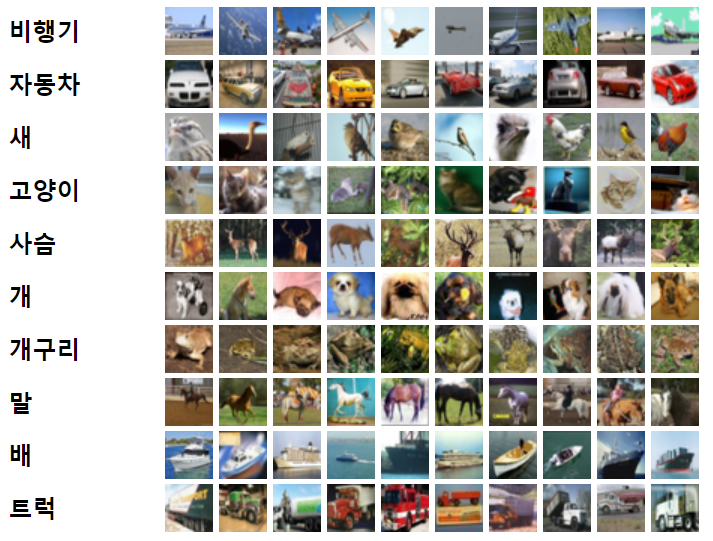

</details>


## 0. Setting

- 런타임 > 런타임 유형 변경 > GPU



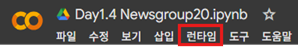

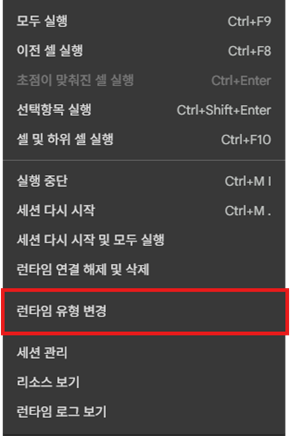

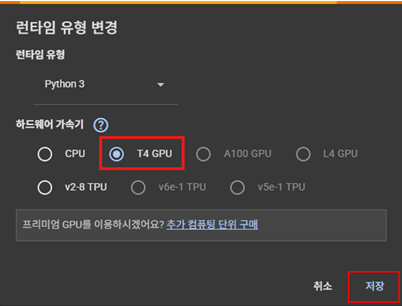

- 필요한 라이브러리 설치 및 호출

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchsummary import summary
from tqdm import tqdm

- GPU 설정

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


- 시드 고정

    - 동일한 실습 환경에서도 모델의 학습 결과가 일관되도록 랜덤성을 최소화
    - 이를 통해 코드 실행 시 매번 동일한 결과를 재현

In [3]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## 1. Pre-Training & Fine-Tuning

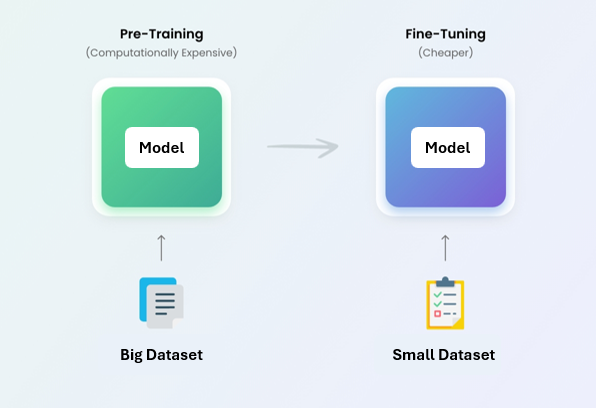

- **Pre-Training** : 모델을 미리 대규모 데이터로 학습하여 따로 저장해놓는 과정
  - 다양하고 많은 양의 데이터로 학습되기에, 광범위한 Task에 사용될 수 있음
  - CIFAR-10 분류, 고양이 vs 강아지 분류, 의료 영상에서 암 여부 판단, 위성 이미지 분석 등등
- **Fine-Tuning** : 저장한 Pre-Trained 모델을 불러오고, 우리의 Task(**Downstream Task**)에 맞는 소규모 데이터로 추가 학습하여 성능을 일부 높이는 과정
  - CIFAR-10을 분류하는게 우리의 Task라면 CIFAR-10 이미지를 추가적으로 학습하여 기존 Pre-Trained 모델보다 성능을 일부 상승시킬 수 있음
  - 일반적으로 모델 전체를 fine-tuning 하기 보다는, 일부 layer의 weight만 업데이트(학습)하는 경우가 많음

- PyTorch에서는 `models` 라는 라이브러리에서 다양한 Pre-Trained된 모델(VggNet, ResNet 등)을 제공
  - 특히 VggNet과 ResNet 은 ImageNet이라는 대규모 이미지 데이터셋으로 학습됨
  

  - <details>
  <summary>ImageNet 상세</summary>

    - 120만장이 넘는 이미지를 포함하고 있는 대규모 데이터셋
    - 일상에서 발견할 수 있는 Object들에 대한 224x224 크기의 컬러 이미지
    - 총 1000개의 클래스
    
    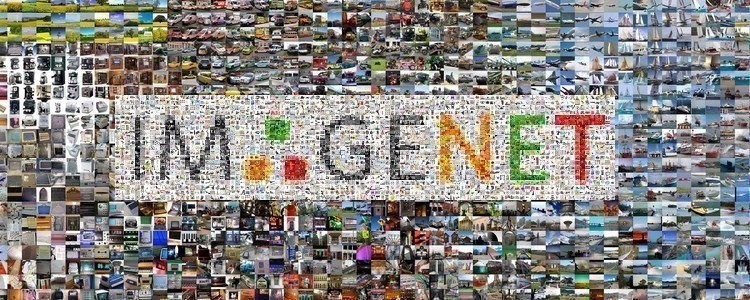
  

  </details>

## 2. VGGNet

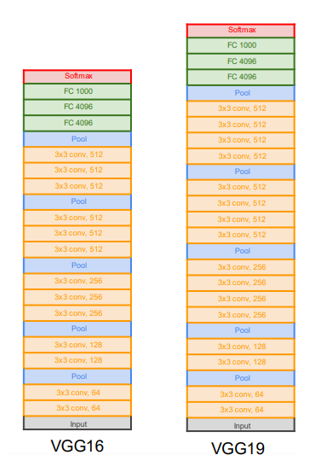

- VGGNet은 모든 Convolution의 Kernel Size를 3×3으로 통일하고, 규칙적인 구조로 깊은 네트워크를 쌓아 올린 대표적인 CNN 모델
- layer 수에 따라 VGG16, VGG19 모델로 나뉨

#### 2.1 PreTrained 된 VGG16 모델 불러오기 & 모델 구조 확인


- `models.vgg16(pretrained=True)` : PreTrained된 VGG16 모델을 불러오는 함수
- 불러온 모델을 출력하거나, `summary` 함수를 통해 모델의 구조와 layer 구성 등을 확인해볼 수 있음

In [63]:
vgg16_model = models.vgg16(pretrained=True).to(device)

In [64]:
summary(vgg16_model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [65]:
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### 2.2 Fine-Tuning을 통해 CIFAR-10 데이터 셋 분류하기

- CIFAR-10 데이터 셋 불러오기

In [66]:
# ToTensor + Normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 불러오기
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Dataloader 구축
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


- VGG16의 마지막 output 크기는 1000인데, 현재 분류하려는 CIFAR-10은 클래스가 총 10개
- 마지막 layer를 올바른 output 크기의 layer로 교체
  - nn.Linear(4096,1000) → nn.Linear(4096,10)

In [67]:
import torch.nn as nn

vgg16_model.classifier[6] = nn.Linear(4096, 10)
vgg16_model = vgg16_model.to(device)

- CIFAR-10 데이터셋으로 fine-tuning
  - 적은 학습 횟수로도 일반적인 CNN보다 좋은 성능을 보임

In [69]:
def train_eval(model, optimizer, train_loader, test_loader, device, epochs=10):
    import torch.nn as nn
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader,"training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        total = 0
        correct = 0
        total_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader,"testing"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                total_test_loss += loss.item()

                _, preds = outputs.max(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = correct / total
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.4f}")

    return train_losses, test_losses, test_accuracies

In [72]:
optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=0.0005)

set_seed(0)
train_losses, test_losses, test_accuracies = train_eval(vgg16_model, optimizer, train_loader, test_loader, device, epochs=3)

testing: 100%|██████████| 79/79 [00:03<00:00, 19.83it/s]


[Epoch 1] Train Loss: 0.4270 | Test Loss: 0.7117 | Test Acc: 0.8085


testing: 100%|██████████| 79/79 [00:04<00:00, 17.46it/s]


[Epoch 2] Train Loss: 0.3845 | Test Loss: 0.5214 | Test Acc: 0.8480


testing: 100%|██████████| 79/79 [00:05<00:00, 15.32it/s]

[Epoch 3] Train Loss: 0.2820 | Test Loss: 0.5833 | Test Acc: 0.8449


In [ ]:
# 예측 결과 시각화

# CIFAR-10 클래스 이름
labels_map = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# 모델 시각화용 출력 함수
def visualize_predictions(model, test_dataset, device, rows=6, cols=6):
    fig = plt.figure(figsize=(1.5 * cols, 1.5 * rows))
    model.eval()

    for i in range(1, rows * cols + 1):
        data_idx = np.random.randint(len(test_dataset))

        # 이미지 + 라벨 불러오기
        img, true_label = test_dataset[data_idx]
        input_img = img.unsqueeze(0).to(device)

        # 예측 수행
        with torch.no_grad():
            output = model(input_img)
            _, predicted = output.max(1)

        pred_label = predicted.item()
        true_label = true_label
        pred_name = labels_map[pred_label]
        true_name = labels_map[true_label]

        # 시각화
        ax = fig.add_subplot(rows, cols, i)
        npimg = img.numpy()
        npimg = (np.transpose(npimg, (1, 2, 0)) * 0.5) + 0.5  # unnormalize

        ax.imshow(npimg)
        if pred_label == true_label:
            ax.set_title(f"O {pred_name}", color='blue')
        else:
            ax.set_title(f"X P:{pred_name}\n T:{true_name}", color='red')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(vgg16_model, testset, device, rows=6, cols=6)

  - 빠른 학습을 위해 마지막에 교체한 Linear layer만 학습하기도 함
  - `layer.parameters.requires_grad=True/False`를 통해 특정 layer의 weight의 학습 여부를 결정할 수 있음
  - 물론, 모델 전체를 학습했을 때보다는 꽤나 큰 성능 저하가 있음

In [74]:
only_linear_model = models.vgg16(pretrained=True).to(device)
only_linear_model.classifier[6] = nn.Linear(4096, 10)
only_linear_model = only_linear_model.to(device)

# 1. 모든 파라미터를 freeze
for param in only_linear_model.parameters():
    param.requires_grad = False

# 2. 마지막 교체한 Linear layer만 fine-tuning
for param in only_linear_model.classifier[6].parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, only_linear_model.parameters()), lr=0.0005)

train_losses, test_losses, test_accuracies = train_eval(only_linear_model, optimizer, train_loader, test_loader, device, epochs=3)

testing: 100%|██████████| 79/79 [00:04<00:00, 17.01it/s]


[Epoch 1] Train Loss: 1.3296 | Test Loss: 1.1195 | Test Acc: 0.6081


testing: 100%|██████████| 79/79 [00:04<00:00, 18.60it/s]

[Epoch 2] Train Loss: 1.2403 | Test Loss: 1.0995 | Test Acc: 0.6120


## 3. ResNet


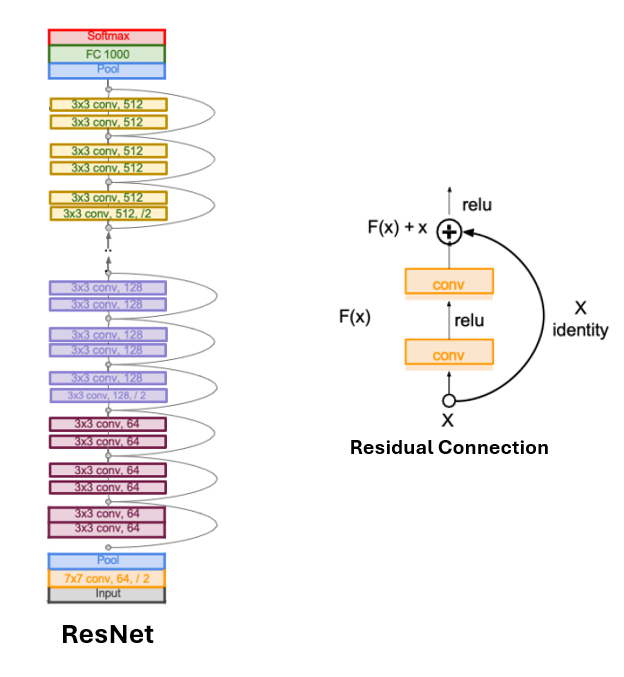

- ResNet은 기존 CNN 모델들에 Residual connection(Skip connection)을 도입하여 gradient vanishing 문제를 효과적으로 해결한 모델
- layer 수와 구조에 따라 ResNet18, ResNet34, ResNet50 등 다양한 모델이 존재함

#### 3.1 PreTrained 된 ResNet 모델 불러오기 & 모델 구조 확인

In [92]:
import torchvision.models as models

resnet18_model = models.resnet18(pretrained=True).to(device)

In [79]:
summary(resnet18_model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [80]:
resnet18_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- Residual Connection은 layer의 `forward` 함수에서 확인할 수 있음

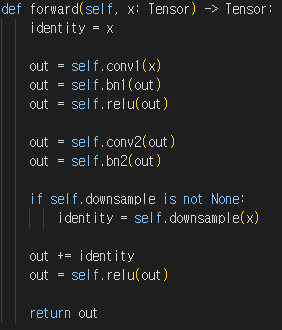

In [86]:
resnet18_model.layer1[0].forward

<bound method BasicBlock.forward of BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)>

#### 3.2 Fine-Tuning을 통해 CIFAR-10 데이터 셋 분류하기

- ResNet의 마지막 output 크기 역시 1000이므로 현재 분류하려는 CIFAR-10은 클래스 수(10개)에 맞게 마지막 layer를 올바른 output 크기의 layer로 교체
  - nn.Linear(512,1000) → nn.Linear(512,10)

In [93]:
import torch.nn as nn

resnet18_model.fc = nn.Linear(512, 10)
resnet18_model = resnet18_model.to(device)

- CIFAR-10 데이터셋으로 fine-tuning
  - 적은 학습 횟수로도 일반적인 CNN보다 좋은 성능을 보임

In [94]:
import torch.optim as optim

optimizer = optim.Adam(resnet18_model.parameters(), lr=0.0005)

set_seed(0)
train_losses, test_losses, test_accuracies = train_eval(resnet18_model, optimizer, train_loader, test_loader, device, epochs=3)

testing: 100%|██████████| 79/79 [00:03<00:00, 23.32it/s]


[Epoch 1] Train Loss: 0.8861 | Test Loss: 0.6949 | Test Acc: 0.7661


testing: 100%|██████████| 79/79 [00:03<00:00, 21.17it/s]


[Epoch 2] Train Loss: 0.5731 | Test Loss: 0.6221 | Test Acc: 0.7942


testing: 100%|██████████| 79/79 [00:02<00:00, 29.23it/s]

[Epoch 3] Train Loss: 0.4439 | Test Loss: 0.5961 | Test Acc: 0.8082


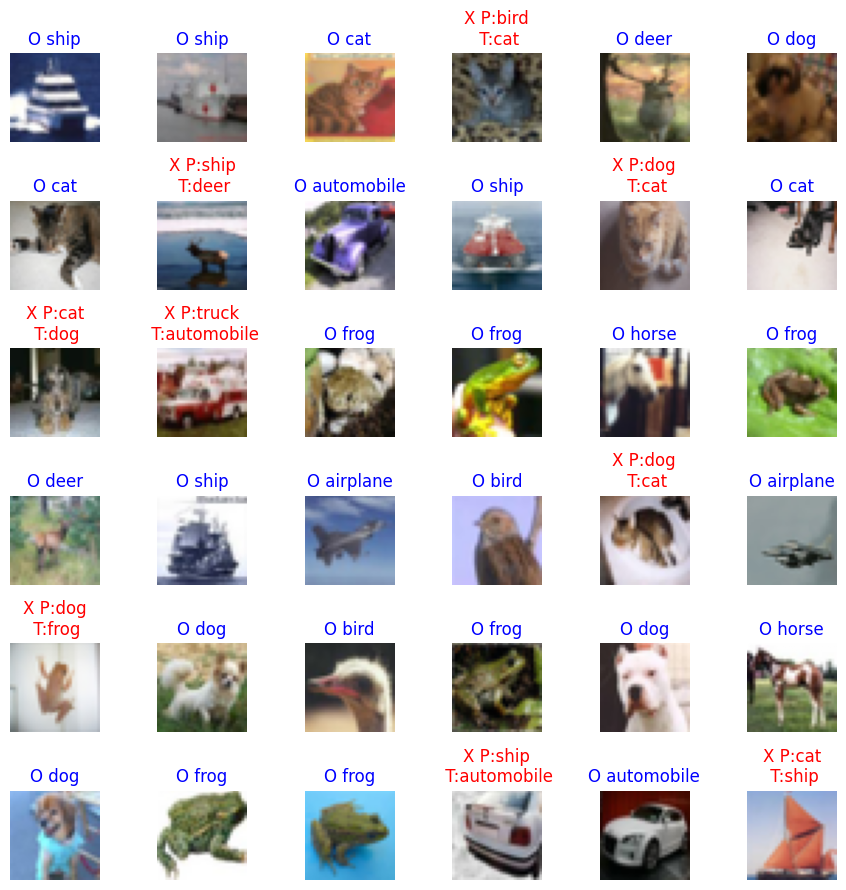

In [96]:
# 예측 결과 시각화

# CIFAR-10 클래스 이름
labels_map = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

visualize_predictions(resnet18_model, testset, device, rows=6, cols=6)